In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores = rp.named_steps['estimator'].get_data()

X, _, y, _, y_scores, _ = train_test_split(df_mf.values,
                                           df_rank.values,
                                           df_scores.values,
                                           test_size=0,
                                           random_state=42)
print(X.shape, y.shape, y_scores.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 40.6 s, sys: 4.09 s, total: 44.7 s
Wall time: 49.7 s


In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class RankDataset(Dataset):
    def __init__(self, X_cont, X_cats, y):
        super().__init__()
        self.X_cont = X_cont.astype(np.float32)
        self.X_cats = X_cats.astype(np.int64)
        self.y = y.astype(np.float32) # 0-1
        
        self.mf_sz = X_cont.shape[1]
        self.fs_sz = len(np.unique(X_cats))
        
    def __len__(self):
        return len(self.X_cont)
    
    def __getitem__(self, idx):
        return [self.X_cont[idx], self.X_cats[idx], self.y[idx]]

In [31]:
import torch.nn as nn
from torch import optim
from project.ranker.neural_ranker import RankNet
from scipy.stats import rankdata

class NeuralNetwork():
    def __init__(self, mf_sz, fs_sz, params):
        self.mf_sz, self.fs_sz = mf_sz, fs_sz
        self.latent_sz = params['latent_sz']
        self.epochs = params['epochs']
        self.lr = params['learning_rate']
        
        self.model = RankNet(mf_sz, fs_sz, self.latent_sz)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        
    def train(self, dl):
        train_losses = []
        for epoch in range(self.epochs):
            train_loss = 0
            for X_cont, X_cats, y in dl:
                train_loss += self.train_step(X_cont, X_cats, y)
            train_losses.append(train_loss) 
        return train_losses
    
    def train_step(self, X_cont, X_cats, y):
        self.model.train()
        self.optimizer.zero_grad()
        preds = self.model(X_cont, X_cats)
        loss = self.criterion(preds.view(-1), y)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def predict(self, dl):
        preds = []
        self.model.eval()
        for X_cont, X_cats, y in dl:
            X_cont.requires_grad_(False)
            X_cats.requires_grad_(False)
            
            pred = self.model(X_cont, X_cats).cpu().detach().numpy()
            preds.extend(pred)
        return np.array([rankdata(x, method='ordinal') for x in \
                         np.reshape(preds, (-1, self.fs_sz))]).astype(int)

In [32]:
def wide2long(X, y):
    n_samples, n_classes = y.shape
    X_cont = np.repeat(X, n_classes, axis=0)
    X_cats = np.array(list(range(n_classes)) * n_samples)
    return X_cont, X_cats.astype(int), y.reshape(-1)

In [33]:
from project.utils.metrics import evaluate_metric

def cv_neuralnet(X, y, y_scores, kfolds, params, verbose_folds=False):
    results = []
    models = []
    X = StandardScaler().fit_transform(X)
    y = (y - y.min()) / (y.max() - y.min())
    for idx, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_trn, y_trn, y_scores_trn = X[trn_idx], y[trn_idx], y_scores[trn_idx]
        X_val, y_val, y_scores_val = X[val_idx], y[val_idx], y_scores[val_idx]
        
        X_trn_cont, X_trn_cats, y_trn_long = wide2long(X_trn, y_trn)
        X_val_cont, X_val_cats, y_val_long = wide2long(X_val, y_val)
        
        trn_ds = RankDataset(X_trn_cont, X_trn_cats, y_trn_long)
        val_ds = RankDataset(X_val_cont, X_val_cats, y_val_long)
        
        neuralnet = NeuralNetwork(trn_ds.mf_sz, trn_ds.fs_sz, params)
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=True)
        neuralnet.train(trn_dl)
        
        trn_dl = DataLoader(trn_ds, batch_size=params['batch_sz'], shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=params['batch_sz'], shuffle=False)
        
        y_pred_trn = neuralnet.predict(trn_dl)
        y_pred_val = neuralnet.predict(val_dl)
        
        trn_spearman = evaluate_metric("spearman", y_trn, y_pred_trn)
        trn_acc_loss = evaluate_metric("mean_acc_loss", y_scores_trn, y_pred_trn)
        val_spearman = evaluate_metric("spearman", y_val, y_pred_val)
        val_acc_loss = evaluate_metric("mean_acc_loss", y_scores_val, y_pred_val)
        
        if verbose_folds:
            print(f'Fold {idx + 1:>3} | '
                  f'Trn_Spearman: {trn_spearman: .4f} | '
                  f'Val_Spearman: {val_spearman: .4f} | '
                  f'Trn_ACCLoss: {trn_acc_loss: .4f} | '
                  f'Val_ACCLoss: {val_acc_loss: .4f}')
            
        results.append((trn_spearman, val_spearman, 
                        trn_acc_loss, val_acc_loss))
        models.append(neuralnet)
        
#         break # 1-fold
          
    results = np.array(results)
    print()
    print(f'Trn_Spearman: {results[:,0].mean(): .4f} +/-{results[:,0].std():.4f} | '
          f'Val_Spearman: {results[:,1].mean(): .4f} +/-{results[:,1].std():.4f}\n'
          f'Trn_ACCLoss:  {results[:,2].mean(): .4f} +/-{results[:,2].std():.4f} | '
          f'Val_ACCLoss:  {results[:,3].mean(): .4f} +/-{results[:,3].std():.4f}')
    print()
    return results, models

In [38]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {
    'latent_sz': 16,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 10,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.5086 | Val_Spearman:  0.2793 | Trn_ACCLoss:  0.0599 | Val_ACCLoss:  0.0888
Fold   2 | Trn_Spearman:  0.5471 | Val_Spearman:  0.1502 | Trn_ACCLoss:  0.0330 | Val_ACCLoss:  0.2265
Fold   3 | Trn_Spearman:  0.5189 | Val_Spearman:  0.1062 | Trn_ACCLoss:  0.0501 | Val_ACCLoss:  0.0419
Fold   4 | Trn_Spearman:  0.5227 | Val_Spearman:  0.2308 | Trn_ACCLoss:  0.0585 | Val_ACCLoss:  0.0924
Fold   5 | Trn_Spearman:  0.5264 | Val_Spearman:  0.3553 | Trn_ACCLoss:  0.0566 | Val_ACCLoss:  0.0240
Fold   6 | Trn_Spearman:  0.5033 | Val_Spearman:  0.1126 | Trn_ACCLoss:  0.0504 | Val_ACCLoss:  0.2700
Fold   7 | Trn_Spearman:  0.4931 | Val_Spearman:  0.1667 | Trn_ACCLoss:  0.0604 | Val_ACCLoss:  0.1191
Fold   8 | Trn_Spearman:  0.5186 | Val_Spearman:  0.0998 | Trn_ACCLoss:  0.0666 | Val_ACCLoss:  0.0761
Fold   9 | Trn_Spearman:  0.5424 | Val_Spearman:  0.3049 | Trn_ACCLoss:  0.0499 | Val_ACCLoss:  0.0804
Fold  10 | Trn_Spearman:  0.5027 | Val_Spearman:  0.0092 | Trn_ACCLoss:  

## 100-fold run

In [24]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {
    'latent_sz': 16,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 10,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.4781 | Val_Spearman:  0.1447 | Trn_ACCLoss:  0.0452 | Val_ACCLoss:  0.1400
Fold   2 | Trn_Spearman:  0.5380 | Val_Spearman:  0.1419 | Trn_ACCLoss:  0.0283 | Val_ACCLoss:  0.2473
Fold   3 | Trn_Spearman:  0.5638 | Val_Spearman:  0.2344 | Trn_ACCLoss:  0.0590 | Val_ACCLoss:  0.0260
Fold   4 | Trn_Spearman:  0.5198 | Val_Spearman:  0.3910 | Trn_ACCLoss:  0.0617 | Val_ACCLoss:  0.0527
Fold   5 | Trn_Spearman:  0.4663 | Val_Spearman:  0.4295 | Trn_ACCLoss:  0.0678 | Val_ACCLoss:  0.0109
Fold   6 | Trn_Spearman:  0.5526 | Val_Spearman:  0.3471 | Trn_ACCLoss:  0.0448 | Val_ACCLoss:  0.1649
Fold   7 | Trn_Spearman:  0.4754 | Val_Spearman:  0.2509 | Trn_ACCLoss:  0.0617 | Val_ACCLoss:  0.1527
Fold   8 | Trn_Spearman:  0.5280 | Val_Spearman:  0.1648 | Trn_ACCLoss:  0.0542 | Val_ACCLoss:  0.0706
Fold   9 | Trn_Spearman:  0.5307 | Val_Spearman:  0.3324 | Trn_ACCLoss:  0.0487 | Val_ACCLoss:  0.0793
Fold  10 | Trn_Spearman:  0.5605 | Val_Spearman:  0.0476 | Trn_ACCLoss:  

In [39]:
acc = pd.read_csv('results/ACC_scores.csv')
acc['Neural Net'] = results[:,3]

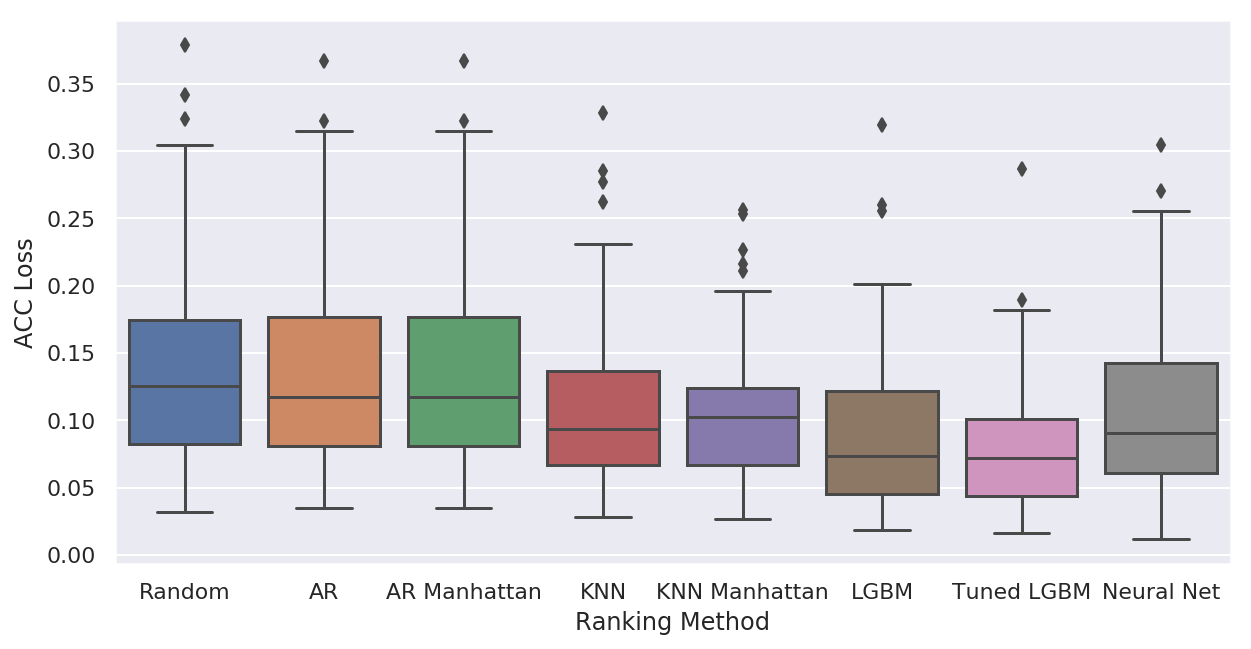

In [40]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 
                               'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

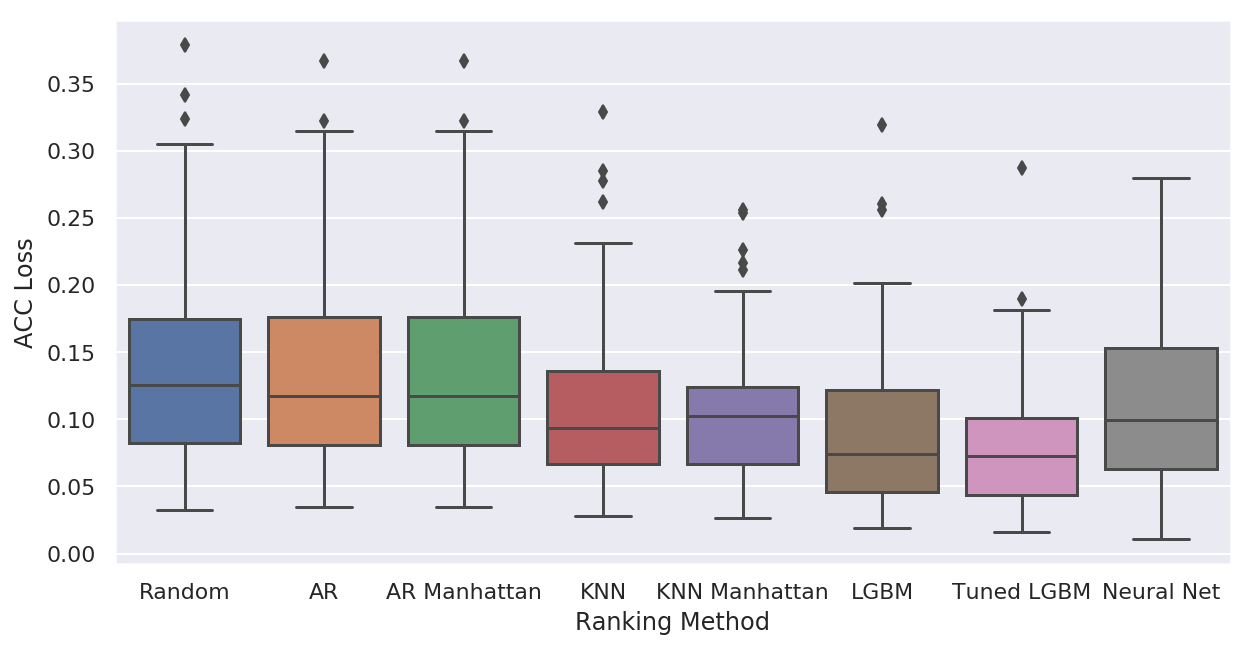

In [27]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 
                               'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

In [18]:
%%time
import lightgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {
    'latent_sz': 8,
    'learning_rate': 1e-3,
    'batch_sz': 16,
    'epochs': 20,
}
results, models = cv_neuralnet(X, y, y_scores, kfolds, params, 
                               verbose_folds=True)

Fold   1 | Trn_Spearman:  0.4016 | Val_Spearman:  0.2958 | Trn_ACCLoss:  0.0900 | Val_ACCLoss:  0.0475
Fold   2 | Trn_Spearman:  0.4162 | Val_Spearman:  0.1648 | Trn_ACCLoss:  0.0765 | Val_ACCLoss:  0.2200
Fold   3 | Trn_Spearman:  0.4731 | Val_Spearman:  0.0907 | Trn_ACCLoss:  0.0750 | Val_ACCLoss:  0.0506
Fold   4 | Trn_Spearman:  0.2892 | Val_Spearman: -0.0119 | Trn_ACCLoss:  0.1031 | Val_ACCLoss:  0.1721
Fold   5 | Trn_Spearman:  0.2659 | Val_Spearman:  0.2161 | Trn_ACCLoss:  0.1085 | Val_ACCLoss:  0.0388
Fold   6 | Trn_Spearman:  0.3848 | Val_Spearman:  0.1273 | Trn_ACCLoss:  0.0708 | Val_ACCLoss:  0.2507
Fold   7 | Trn_Spearman:  0.3310 | Val_Spearman:  0.1071 | Trn_ACCLoss:  0.0767 | Val_ACCLoss:  0.1254
Fold   8 | Trn_Spearman:  0.3862 | Val_Spearman:  0.0577 | Trn_ACCLoss:  0.0632 | Val_ACCLoss:  0.0901
Fold   9 | Trn_Spearman:  0.3938 | Val_Spearman:  0.3443 | Trn_ACCLoss:  0.0936 | Val_ACCLoss:  0.0600
Fold  10 | Trn_Spearman:  0.3585 | Val_Spearman:  0.1291 | Trn_ACCLoss:  

## Bayesian Optimization

In [42]:
from skopt.space import Real, Integer, Categorical

space  = [
    Integer(3, 30, name='latent_sz'),
    Integer(3, 40, name='batch_sz'),
    Integer(1, 50, name='epochs'),
    Real(-4, -1, name='learning_rate'),
]

In [48]:
import gc

all_res = []

def objective(values):
    kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
    params = {
        'latent_sz': int(values[0]),
        'batch_sz': int(values[1]),
        'epochs': int(values[2]),
        'learning_rate': float(10 ** values[3]),
    }
    print('\nNext set of params.....', params)
    res, mod = cv_neuralnet(X, y, y_scores, kfolds, params, 
                                   verbose_folds=False)
    all_res.append(res)
    gc.collect()
    return res[:,3].mean()

In [ ]:
%%time
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_random_starts=10, n_calls=100, random_state=42, verbose=True)
print(f'Best score = {res_gp.fun:.4f}')

Iteration No: 1 started. Evaluating function at random point.

Next set of params..... {'latent_sz': 25, 'batch_sz': 10, 'epochs': 39, 'learning_rate': 0.006173770394704579}

Trn_Spearman:  0.7662 +/-0.0149 | Val_Spearman:  0.1800 +/-0.1547
Trn_ACCLoss:   0.0222 +/-0.0047 | Val_ACCLoss:   0.1036 +/-0.0582

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 137.9646
Function value obtained: 0.1036
Current minimum: 0.1036
Iteration No: 2 started. Evaluating function at random point.

Next set of params..... {'latent_sz': 15, 'batch_sz': 7, 'epochs': 24, 'learning_rate': 0.0010025956902289567}

Trn_Spearman:  0.6736 +/-0.0164 | Val_Spearman:  0.2440 +/-0.1379
Trn_ACCLoss:   0.0367 +/-0.0051 | Val_ACCLoss:   0.0999 +/-0.0547

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 118.3384
Function value obtained: 0.0999
Current minimum: 0.0999
Iteration No: 3 started. Evaluating function at random point.

Next set of params..... {'latent_sz': 7, 'batch_sz': 27

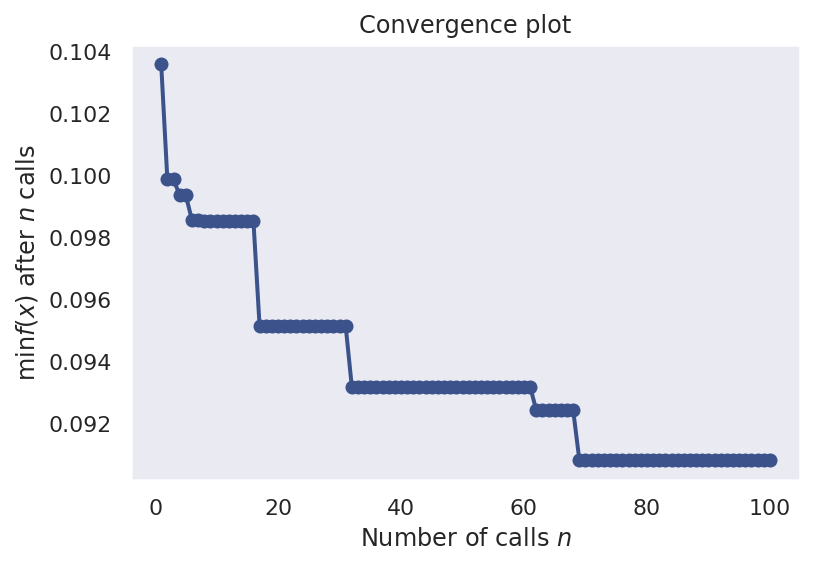

In [52]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [53]:
res_gp.fun, res_gp.x

(0.09081581077640989, [30, 40, 29, -2.62578379490533])

In [62]:
cols = ['iteration', 'ACC_Loss', 'latent_sz', 'batch_sz', 'epochs', 'learning_rate']
gp_results = [[i+1, f, *p] for i, (f, p) in enumerate(zip(res_gp.func_vals, res_gp.x_iters))]
gp_results = pd.DataFrame(gp_results, columns=cols)

In [65]:
gp_results['LR'] = 10 ** gp_results.learning_rate

In [66]:
gp_results.head()

,iteration,ACC_Loss,latent_sz,batch_sz,epochs,learning_rate,LR
0,1,0.103588,25,10,39,-2.209450,0.006174
1,2,0.099881,15,7,24,-2.998874,0.001003
2,3,0.103558,7,27,4,-1.834004,0.014655
3,4,0.099362,28,3,50,-2.147555,0.007119
4,5,0.102451,20,3,2,-2.425676,0.003753


In [96]:
acc = pd.read_csv('results/ACC_scores.csv')
acc['Neural Net'] = all_res[68][:,3]

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


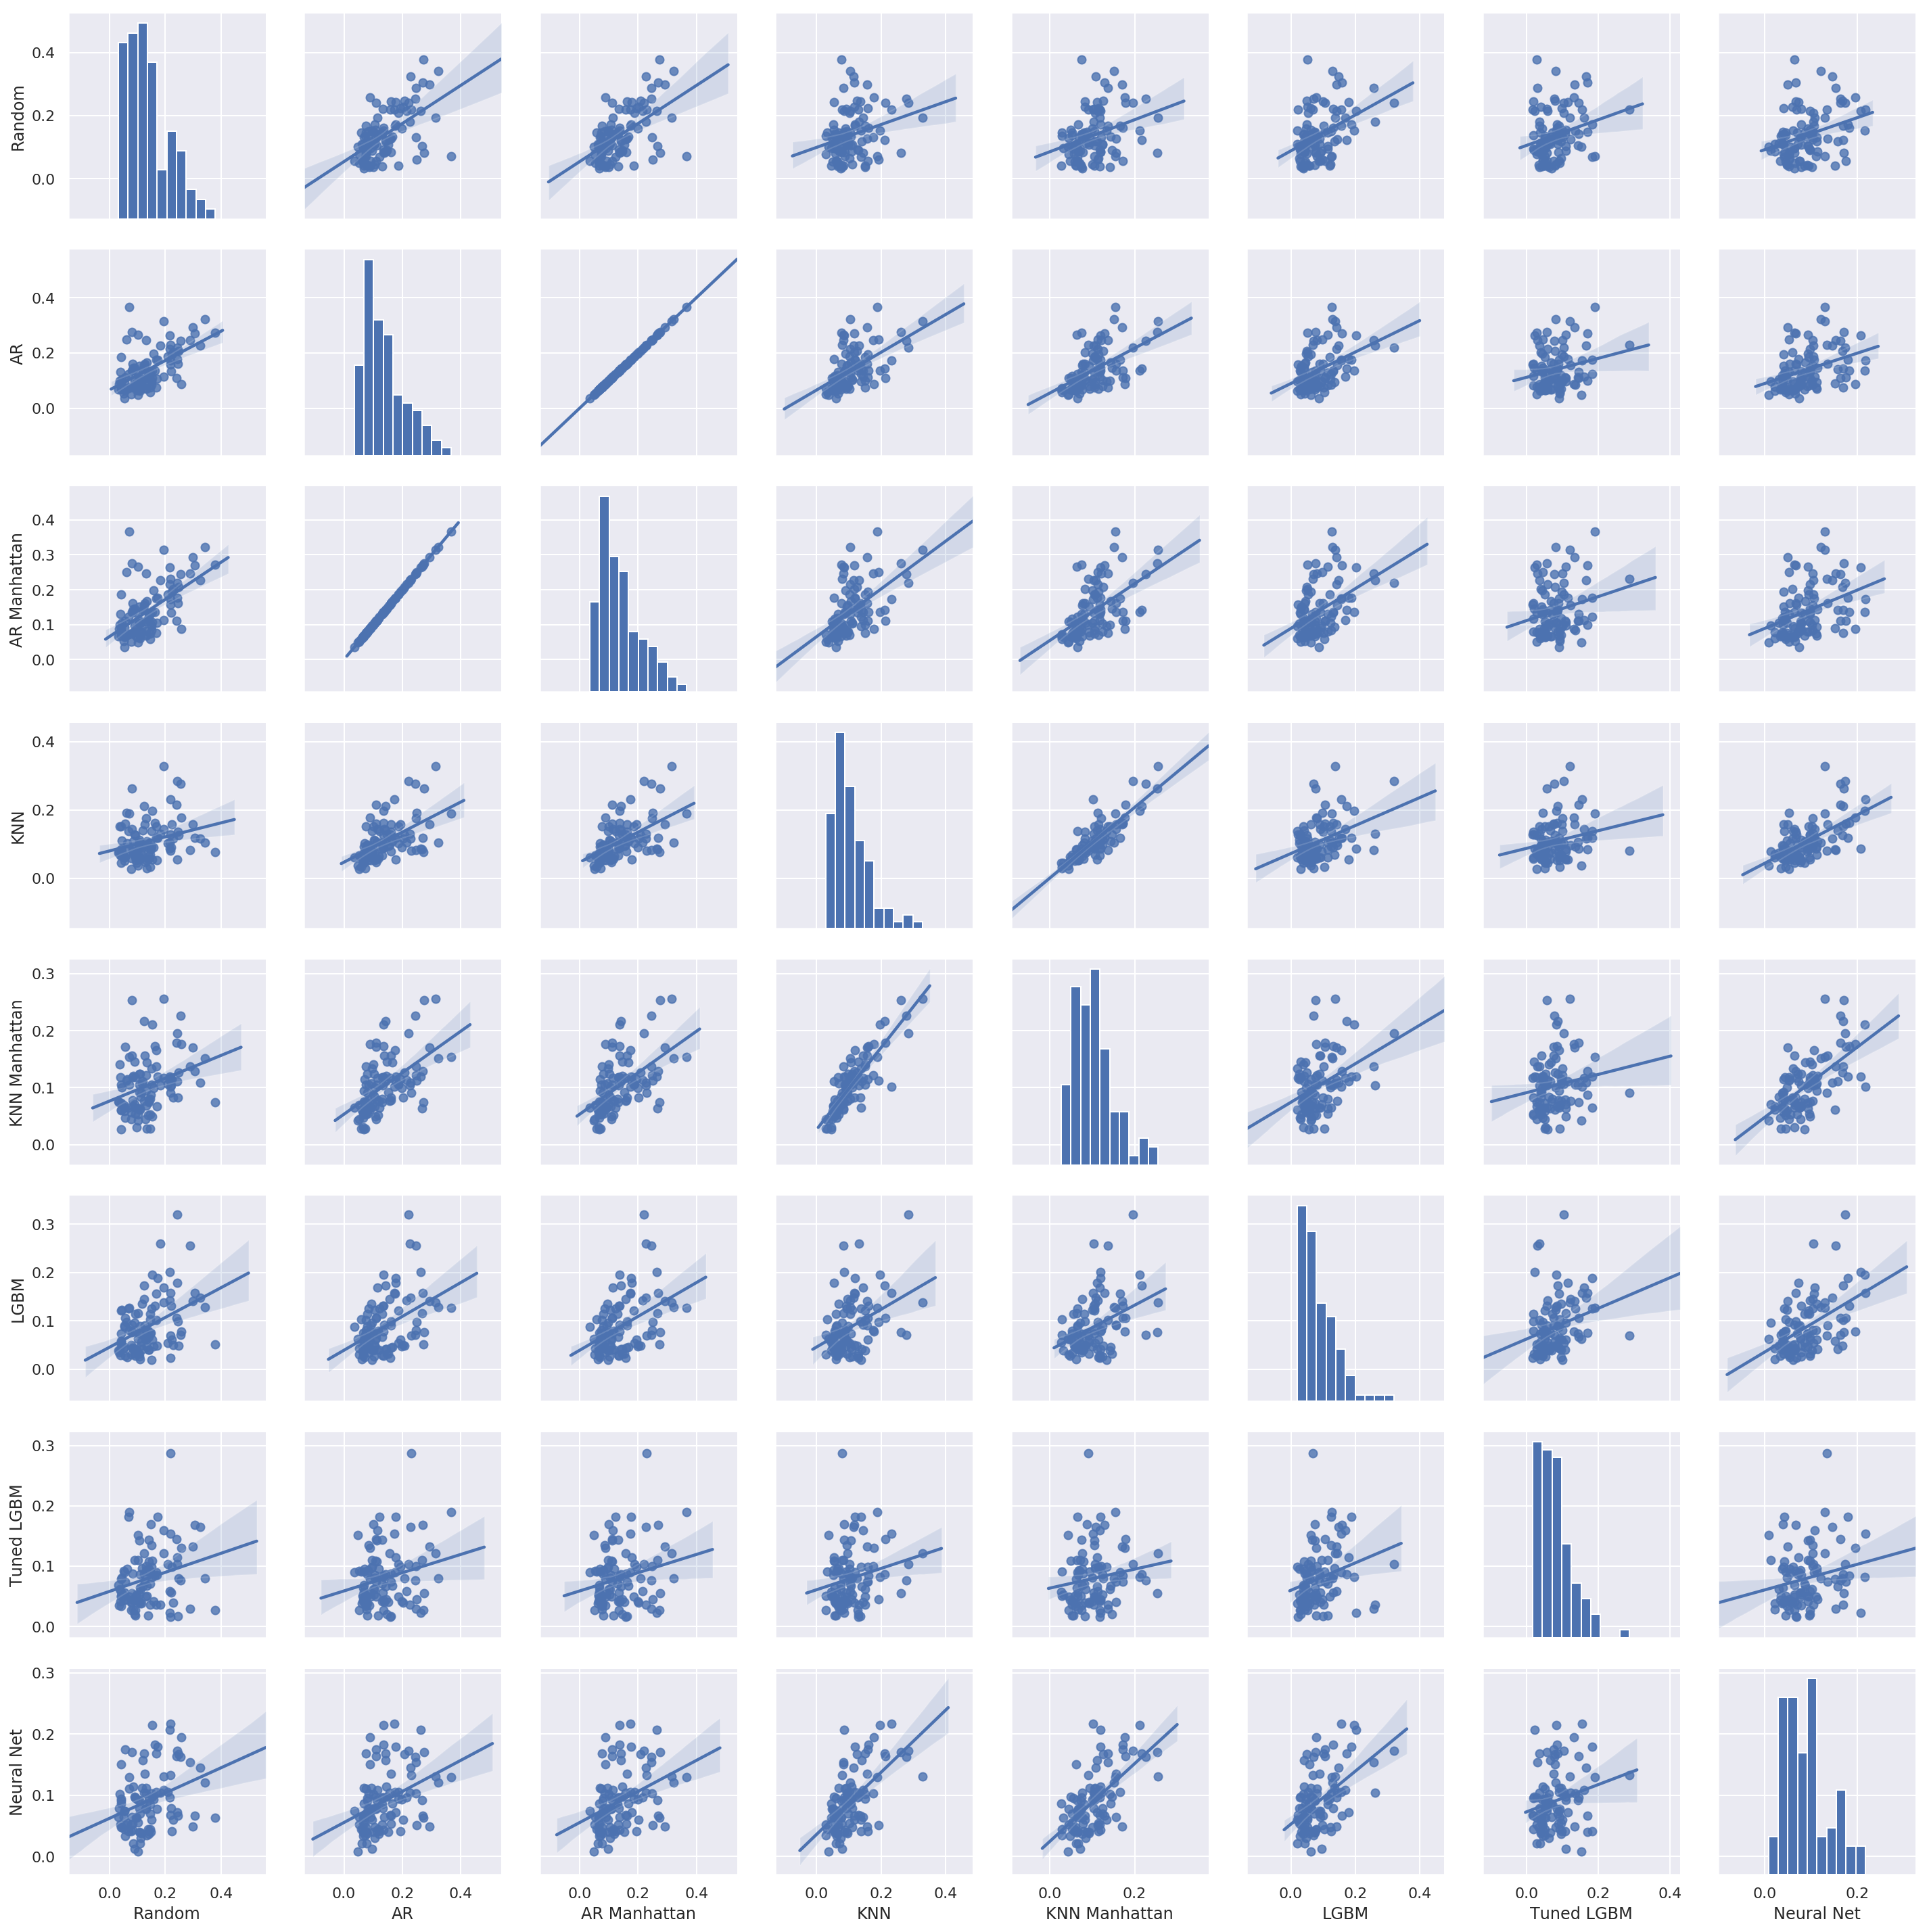

In [97]:
sns.pairplot(acc, kind='reg')

In [99]:
from scipy.stats import ttest_rel, ttest_ind

In [ ]:
ttest_rel(acc['Tuned LGBM'], acc['Random'])

In [100]:
ttest_rel(acc['Tuned LGBM'], acc['Random'])

Ttest_relResult(statistic=-7.356625109429373, pvalue=5.5742952531915925e-11)

In [101]:
ttest_ind(acc['Random'], acc['Tuned LGBM'])

Ttest_indResult(statistic=6.462498891249732, pvalue=7.835354616376866e-10)

In [102]:
ttest_ind(acc['Random'], acc['AR'])

Ttest_indResult(statistic=-0.1076731465426281, pvalue=0.9143639982495921)

In [103]:
ttest_ind(acc['KNN'], acc['LGBM'])

Ttest_indResult(statistic=2.520941285885846, pvalue=0.012492807801841907)

In [104]:
ttest_rel(acc['KNN'], acc['LGBM'])

Ttest_relResult(statistic=3.253713634508583, pvalue=0.0015588381820407123)

In [105]:
ttest_ind(acc['LGBM'], acc['Tuned LGBM'])

Ttest_indResult(statistic=1.091062095983438, pvalue=0.2765714833796128)

In [106]:
ttest_ind(acc['LGBM'], acc['Neural Net'])

Ttest_indResult(statistic=-0.4068317298476274, pvalue=0.6845710111603374)

In [ ]:
ttest_ind(acc['LGBM'], acc['Neural Net'])

In [158]:
pvals = pd.DataFrame({j: {i: ttest_rel(acc[i], acc[j])[1] for i in acc} for j in acc})

In [159]:
cols = pvals.columns
pvals = pvals.loc[cols]
pvals

,Random,AR,AR Manhattan,KNN,KNN Manhattan,LGBM,Tuned LGBM,Neural Net
Random,NaN,8.703256e-01,8.703256e-01,0.000435,2.125400e-05,6.788724e-10,5.574295e-11,1.366554e-08
AR,8.703256e-01,NaN,NaN,0.000003,8.976165e-08,2.958209e-11,7.937310e-12,5.173641e-10
AR Manhattan,8.703256e-01,NaN,NaN,0.000003,8.976165e-08,2.958209e-11,7.937310e-12,5.173641e-10
KNN,4.350140e-04,2.996266e-06,2.996266e-06,NaN,1.634969e-01,1.558838e-03,4.632837e-05,5.426278e-04
KNN Manhattan,2.125400e-05,8.976165e-08,8.976165e-08,0.163497,NaN,6.123061e-03,1.776535e-04,2.297665e-03
LGBM,6.788724e-10,2.958209e-11,2.958209e-11,0.001559,6.123061e-03,NaN,2.060981e-01,5.685943e-01
Tuned LGBM,5.574295e-11,7.937310e-12,7.937310e-12,0.000046,1.776535e-04,2.060981e-01,NaN,6.975869e-02
Neural Net,1.366554e-08,5.173641e-10,5.173641e-10,0.000543,2.297665e-03,5.685943e-01,6.975869e-02,NaN


In [160]:
1.249281e-02

0.01249281

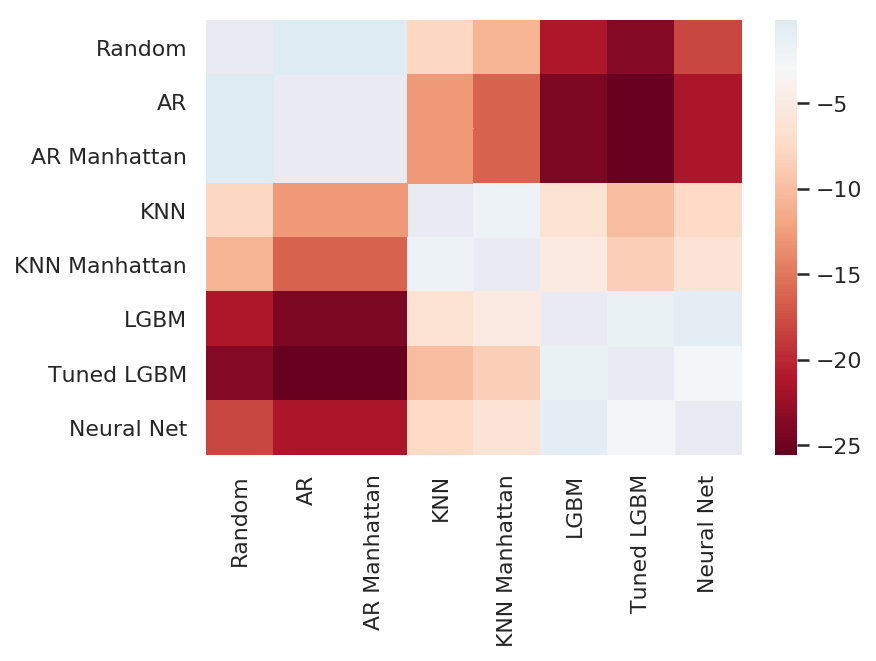

In [161]:
sns.heatmap(np.log(pvals), cmap='RdBu', center=-3)

In [162]:
np.log(0.05)

-2.995732273553991

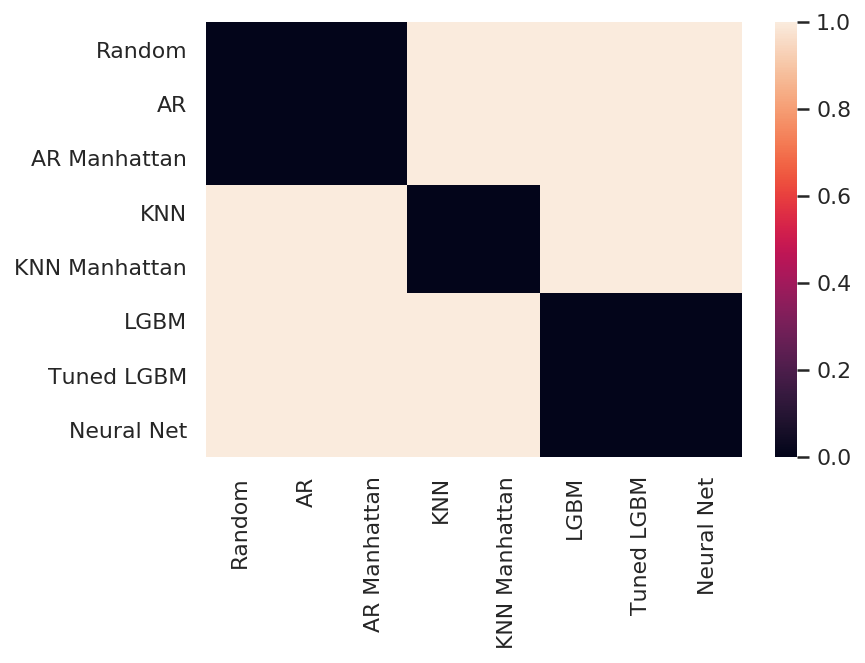

In [163]:
sns.heatmap((pvals < 0.01).astype(float))

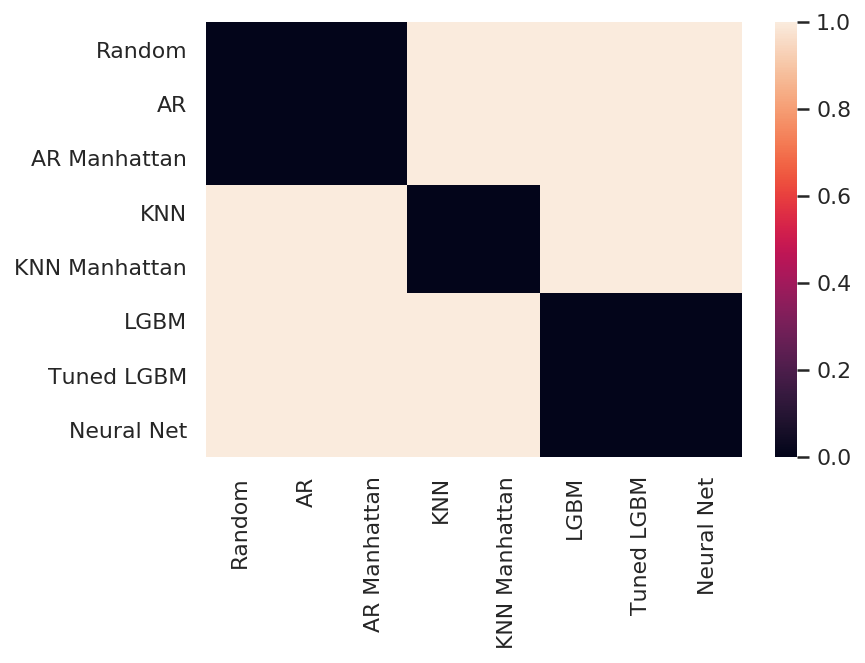

In [164]:
sns.heatmap((pvals < 0.05).astype(float))

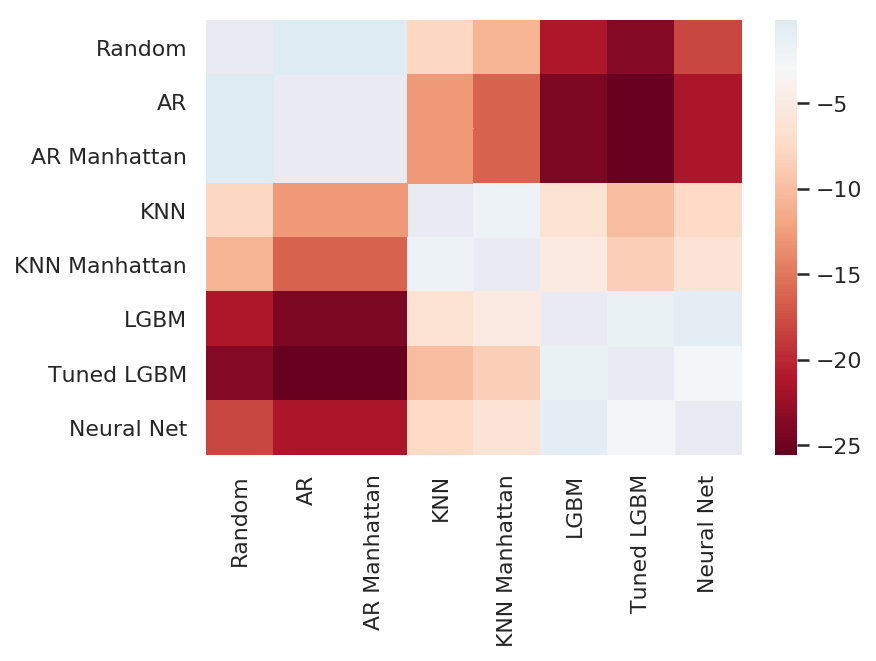

In [165]:
sns.heatmap(np.log(pvals), cmap='RdBu', center=-3)

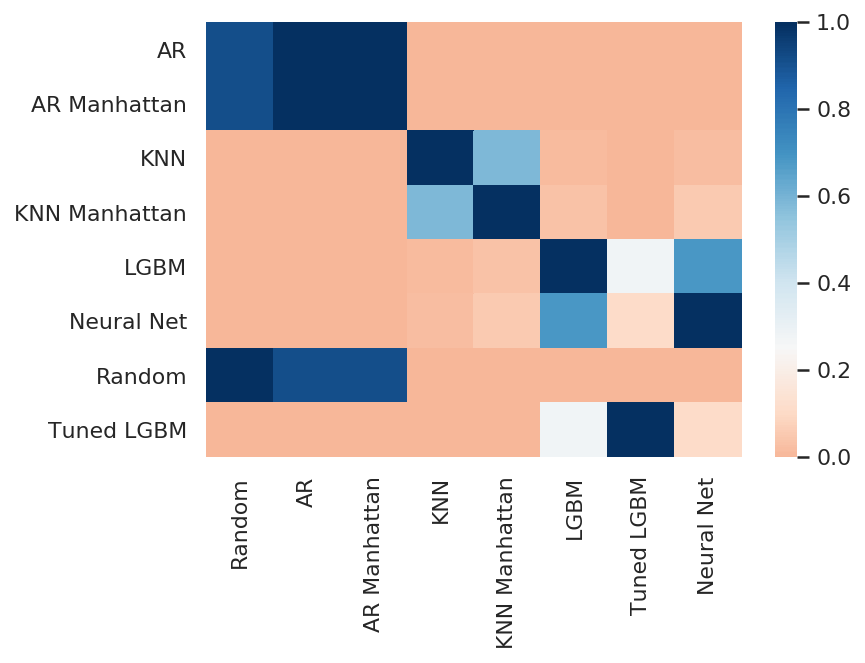

In [112]:
sns.heatmap(pvals, cmap='RdBu', center=0.25, )

In [95]:
acc.to_csv('results/best_results_neuralnet.csv', index=False)

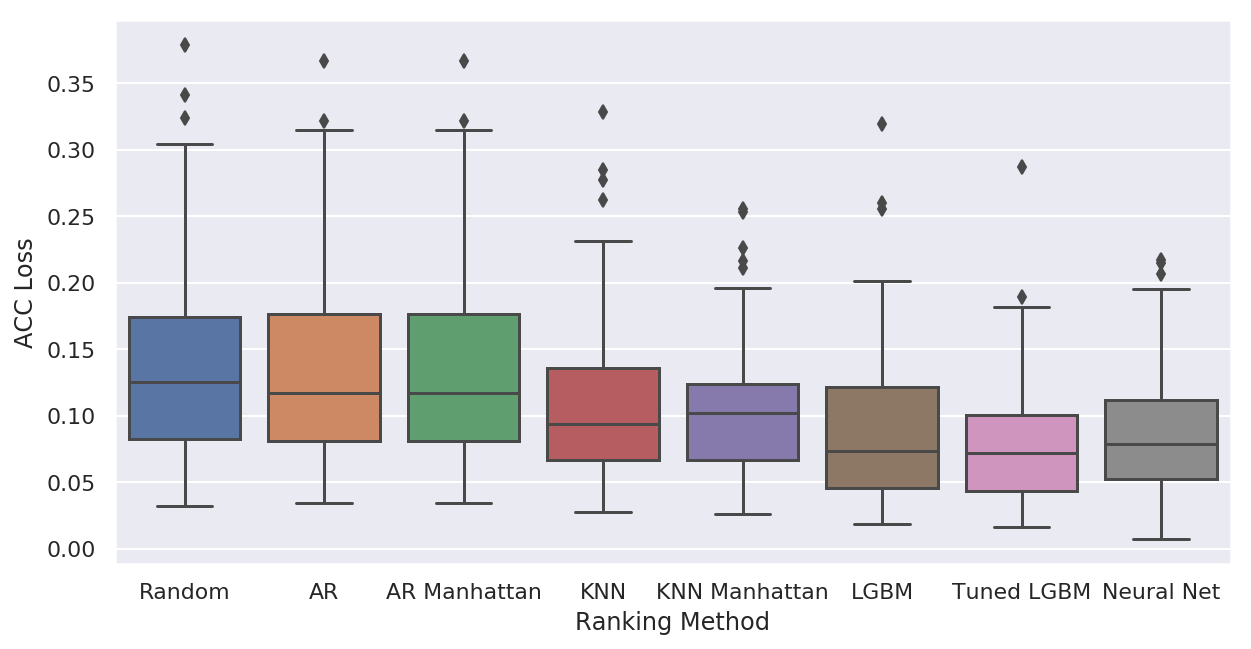

In [92]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 
                               'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

## New figures

In [130]:
acc = pd.read_csv('results/best_results_neuralnet.csv')

In [131]:
acc.head()

,Random,AR,AR Manhattan,KNN,KNN Manhattan,LGBM,Tuned LGBM,Neural Net
0,0.158776,0.198076,0.198076,0.089630,0.099358,0.046732,0.041754,0.093010
1,0.152760,0.136300,0.136300,0.197367,0.211131,0.195062,0.082368,0.215226
2,0.035647,0.086997,0.086997,0.078562,0.074744,0.034662,0.035238,0.078762
3,0.208092,0.186415,0.186415,0.103010,0.106658,0.054068,0.103273,0.105159
4,0.054224,0.064461,0.064461,0.050849,0.059009,0.045572,0.049861,0.044439


In [154]:
acc2 = acc[['Random', 'AR', 'KNN', 'KNN Manhattan', 'LGBM', 'Tuned LGBM', 'Neural Net']]

In [155]:
cols = ['Random\nRanking', 'Average\nRanking', 'KNN\n(Euclidean)', 'KNN\n(Manhattan)', 'LGBM', 'Optimized\nLGBM', 'Neural Net']
acc2.columns = cols
acc2.head()

,Random Ranking,Average Ranking,KNN (Euclidean),KNN (Manhattan),LGBM,Optimized LGBM,Neural Net
0,0.158776,0.198076,0.089630,0.099358,0.046732,0.041754,0.093010
1,0.152760,0.136300,0.197367,0.211131,0.195062,0.082368,0.215226
2,0.035647,0.086997,0.078562,0.074744,0.034662,0.035238,0.078762
3,0.208092,0.186415,0.103010,0.106658,0.054068,0.103273,0.105159
4,0.054224,0.064461,0.050849,0.059009,0.045572,0.049861,0.044439


In [156]:
acc2 = pd.melt(acc2, value_vars=cols, var_name='Ranking Method', 
               value_name='Mean PLC Value')

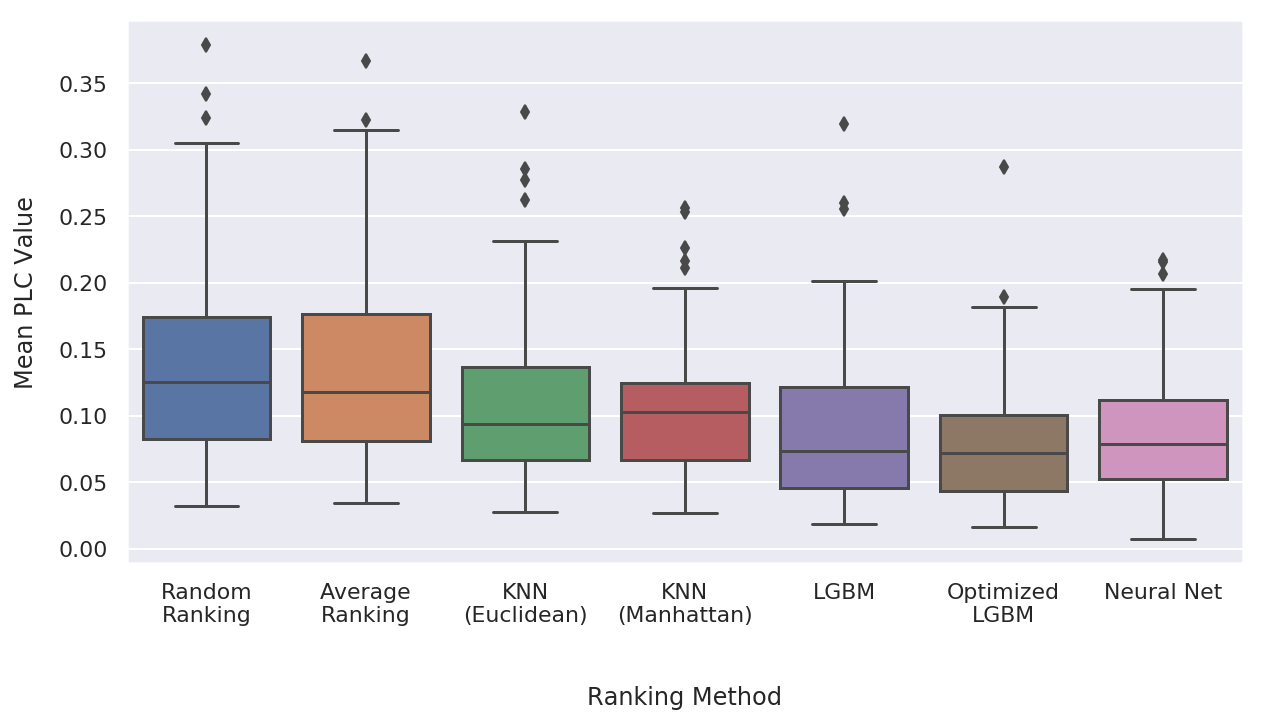

In [157]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10
sns.boxplot(x='Ranking Method', y='Mean PLC Value', data=acc2)

In [90]:
all_res[68][:,3].mean()

0.09081581077640989

In [67]:
gp_results.sort_values('ACC_Loss').head(10)

,iteration,ACC_Loss,latent_sz,batch_sz,epochs,learning_rate,LR
68,69,0.090816,30,40,29,-2.625784,0.002367
80,81,0.092054,30,3,38,-3.240813,0.000574
61,62,0.092418,30,3,50,-3.203366,0.000626
72,73,0.092654,30,20,43,-2.747090,0.001790
97,98,0.092677,30,24,38,-2.800820,0.001582
84,85,0.092771,30,3,38,-3.239459,0.000576
66,67,0.092961,30,3,50,-3.196949,0.000635
31,32,0.093176,30,3,50,-3.127643,0.000745
87,88,0.093515,30,3,40,-3.281968,0.000522
74,75,0.093706,18,40,12,-1.489781,0.032376


In [ ]:
from skopt.space import Real, Integer, Categorical

space  = [
    Integer(3, 30, name='latent_sz'),
    Integer(3, 40, name='batch_sz'),
    Integer(1, 50, name='epochs'),
    Real(-4, -1, name='learning_rate'),
]

In [68]:
gp_results.to_csv('results/neuralnet_gp_optimization.csv', index=False)

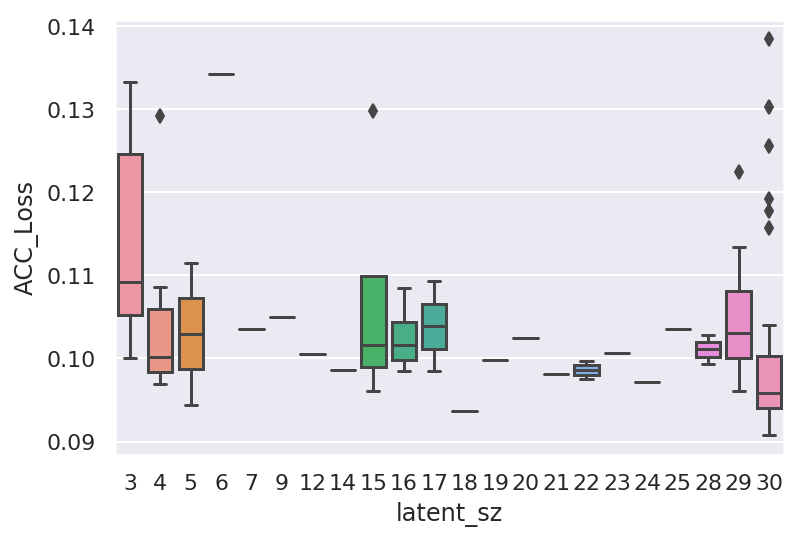

In [69]:
sns.boxplot(x='latent_sz', y='ACC_Loss', data=gp_results)

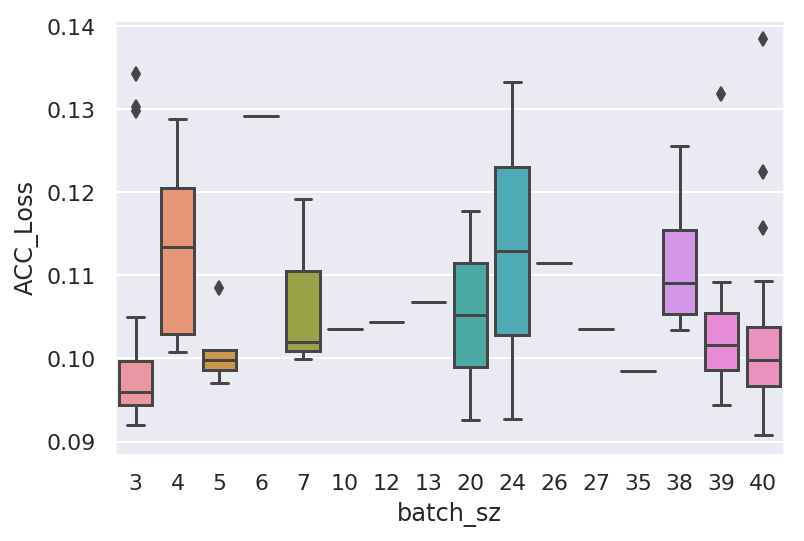

In [70]:
sns.boxplot(x='batch_sz', y='ACC_Loss', data=gp_results)

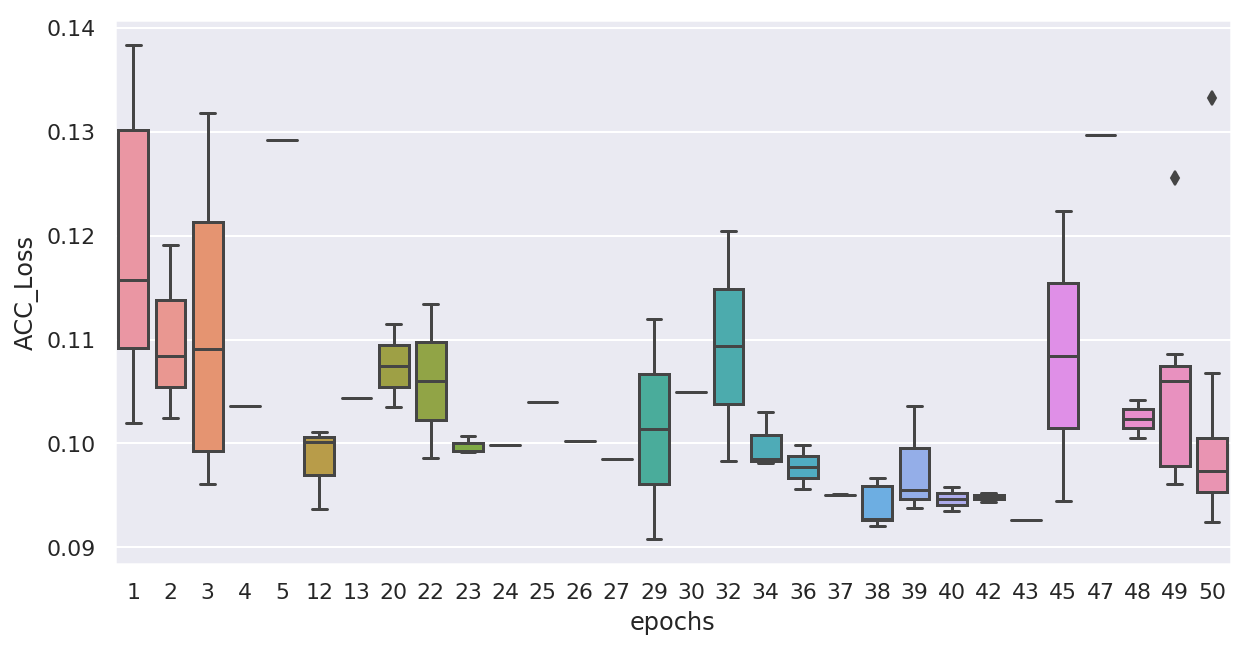

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='epochs', y='ACC_Loss', data=gp_results, ax=ax)

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


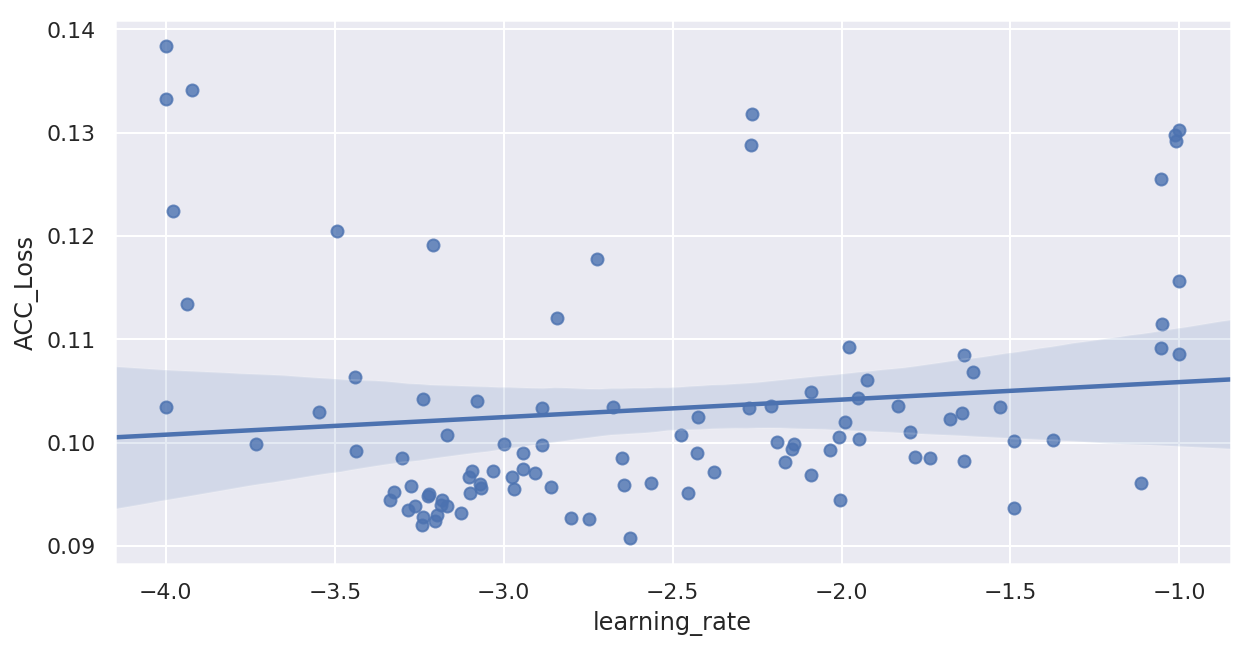

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x='learning_rate', y='ACC_Loss', data=gp_results, ax=ax)

In [87]:
10 ** -2.65

0.00223872113856834

In [84]:
10 ** - 3.25

0.0005623413251903491

In [83]:
10 ** -1.5

0.03162277660168379

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


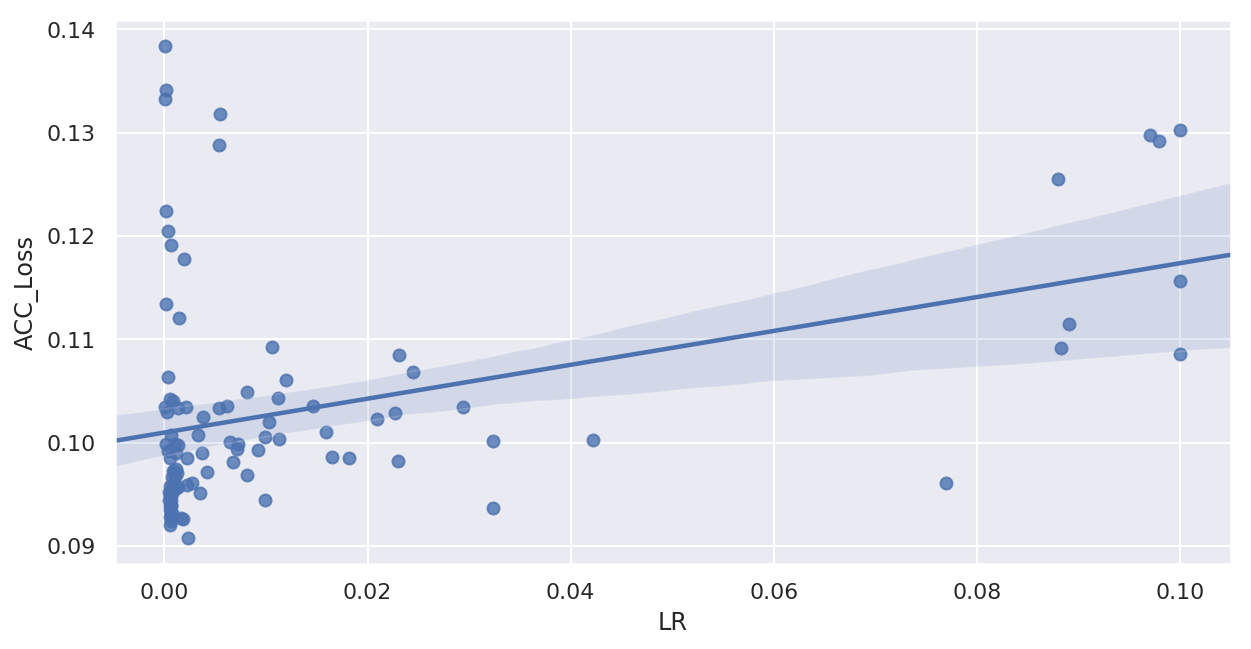

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x='LR', y='ACC_Loss', data=gp_results, ax=ax)

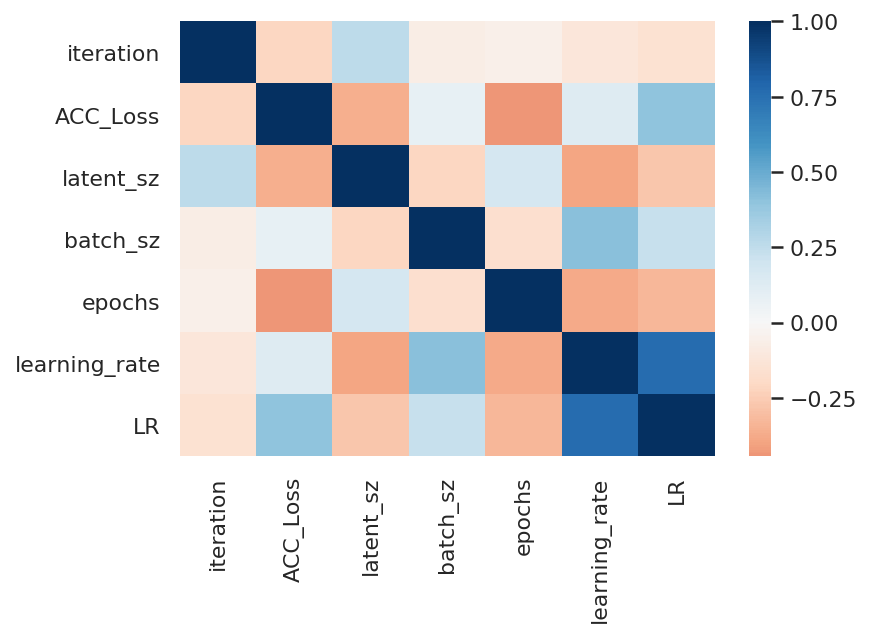

In [77]:
sns.heatmap(gp_results.corr(), cmap='RdBu', center=0)

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


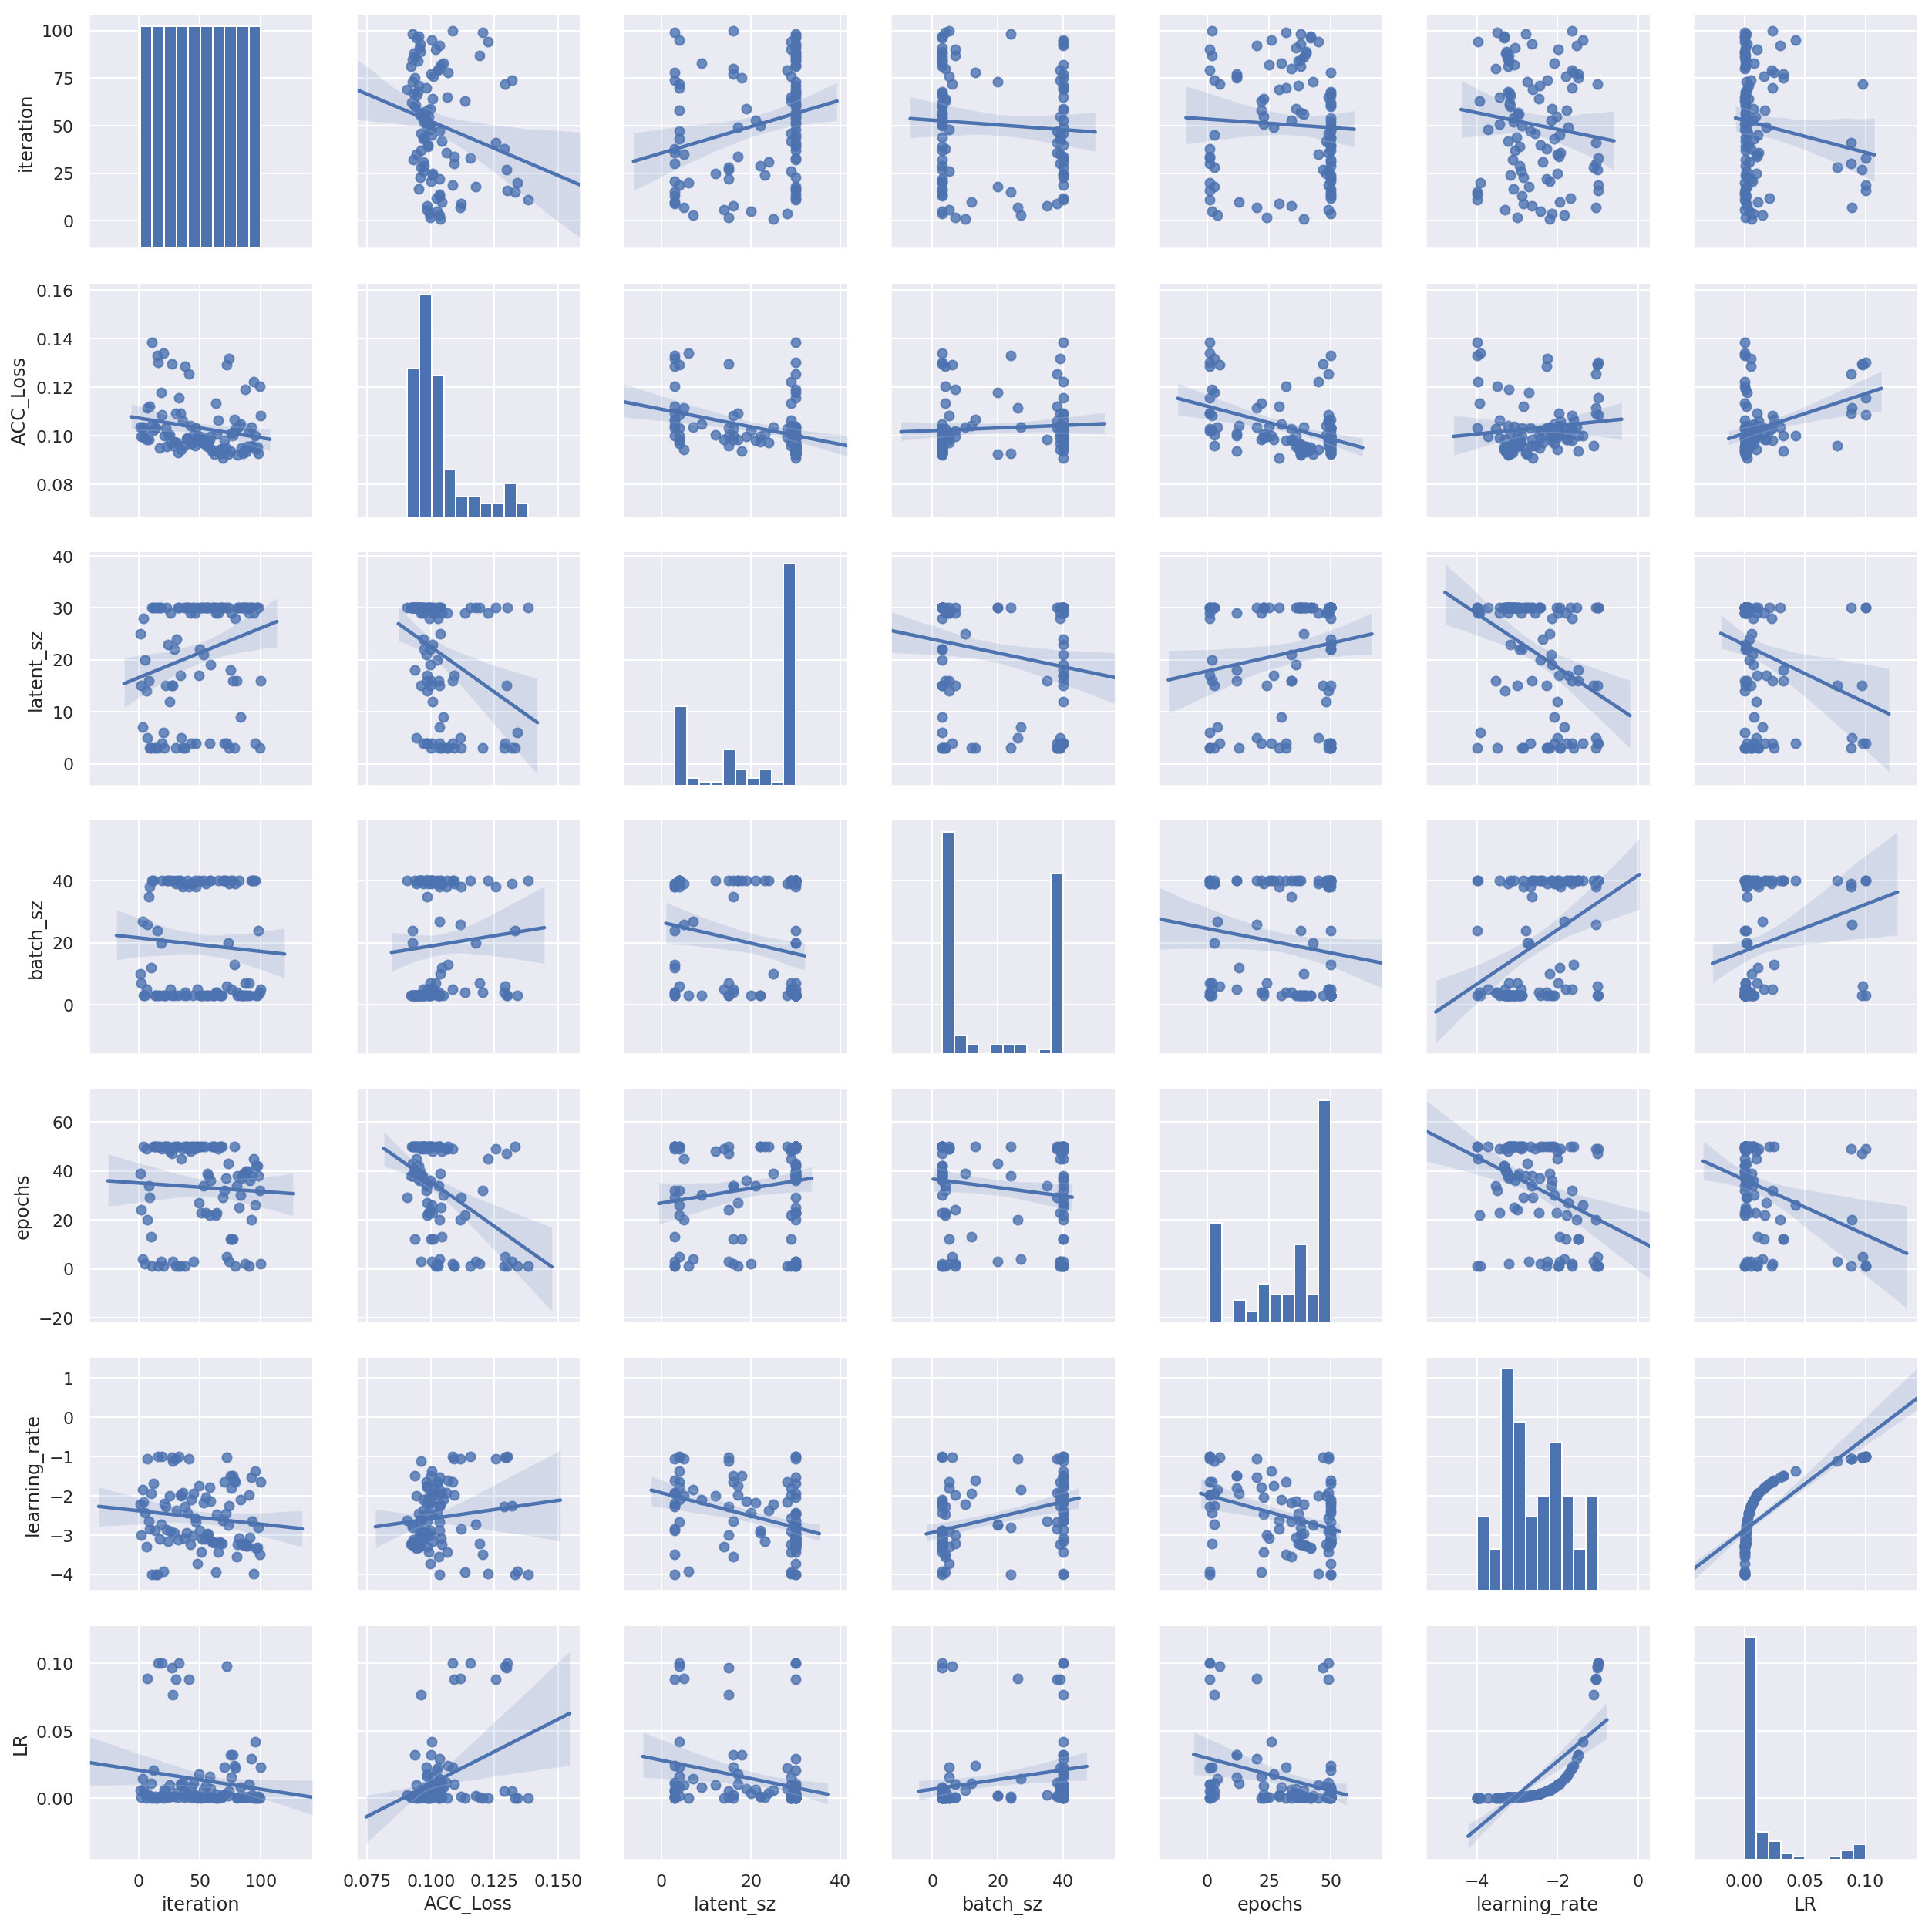

In [82]:
sns.pairplot(gp_results, kind='reg')